<a href="https://colab.research.google.com/github/kylemath/DeepEEG/blob/master/notebooks/DeepEEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DeepEEG


#Connect to Google Drive

In [1]:
#mount google drive to load own images, follow link and get code and paste in below
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#Install and Setup 

In [2]:
!pip install mne
from mne import pick_types, viz, io, Epochs 
from mne import channels, find_events, concatenate_raws
from mne import read_evokeds
from mne.time_frequency import tfr_morlet

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.precision = 4

import numpy as np
from numpy import genfromtxt

from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,12)

import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Flatten, Conv2D, MaxPooling2D, LSTM
from keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

#install ngork for tensorflow viz
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


    100% |████████████████████████████████| 6.2MB 5.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/59/23/bb/ebafe2eae31064edfb9b384131abd0ec562a9418601cde6d69
Successfully built mne


Using TensorFlow backend.


--2019-02-01 22:49:46--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.172.177.65, 34.232.181.106, 52.204.188.97, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.172.177.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.64MB/s    in 0.5s    

2019-02-01 22:49:47 (9.64 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


#Utilities

In [0]:
#find the factors of a number |to add extra dimension for CNN|
def factors(n):
      return [i for i in range(1, n + 1) if not n%i]
  
##Setup TensorFlow
def SetupTensorFlow():
  
  #run tensorboard
  LOG_DIR = './log'
  get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6007 &'
      .format(LOG_DIR)
  )

  #run ngork
  get_ipython().system_raw('./ngrok http 6007 &')

  #get url
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


#Load data function

In [0]:
#load in data files
def load_data(filename,data_type='muse',plot_sensors=True,plot_raw=True,plot_raw_psd=True,stim_channel=False, ):  
  
  #load data from eeg-notebooks muse 
  if data_type == 'muse':
    print('Muse data load')
  
  #load .vhdr files from brain vision recorder
  if data_type == 'recorder':
    raw = io.read_raw_brainvision(filename, 
                            montage='standard_1020', 
                            eog=('HEOG', 'VEOG'), 
                            preload=True,stim_channel=stim_channel)

    #set sampling rate
    sfreq = raw.info['sfreq']
    print('Sampling Rate = ' + str(sfreq))

    #load channel locations
    print('Loading Channel Locations')
    if plot_sensors:
      raw.plot_sensors(show_names='True')

    ##Plot raw data
    if plot_raw:
      raw.plot(n_channels=16, block=True)

     #plot raw psd 
    if plot_raw_psd:
      raw.plot_psd(fmin=.1, fmax=100 ) 
  
  return raw, sfreq

#Preprocessing Function

In [0]:
def preprocess(raw, event_id, event_names, plot_psd=True, filter_data=True, 
               eeg_filter_highpass=1, plot_events=True, epoch_time=(-1,2), 
               baseline=(-.2,0), rej_thresh_uV=100,
               epoch_decim=1, plot_electrodes=True,
               plot_erp=True):

  nsfreq = sfreq/epoch_decim #create new output freq for after epoch or wavelet decim
  tmin=epoch_time[0] 
  tmax=epoch_time[1] 
  eeg_filter_lowpass = nsfreq/2.5  #lower to avoid aliasing from decim

  #Filtering

  if filter_data:             
    print('Filtering Data')
    raw.filter(eeg_filter_highpass,eeg_filter_lowpass, 
               method='iir', verbose='WARNING' )
  
  if plot_psd:
    raw.plot_psd(fmin=eeg_filter_highpass, fmax=nsfreq/2 ) 
   
  #artifact rejection
  rej_thresh = rej_thresh_uV*1e-6

  #Epoching
  events = find_events(raw,shortest_event=1)
  color = {event_nums[0]: 'red', event_nums[1]: 'black'}

  #plot event timing
  if plot_events:
    viz.plot_events(events, sfreq, raw.first_samp, color=color,
                        event_id=event_id)

  #Constructevents
  epochs = Epochs(raw, events=events, event_id=event_id, 
                  tmin=tmin, tmax=tmax, baseline=baseline, 
                  preload=True,reject={'eeg':rej_thresh},
                  verbose=False, decim=epoch_decim)
  print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
   
  if plot_electrodes or plot_erp:
    evoked_zero = epochs[event_names[0]].average()
    evoked_one = epochs[event_names[1]].average()  
  
  ## plot ERP at each electrode
  if plot_electrodes:
    pick = pick_types(epochs.info, meg=False, eeg=True, eog=False)
    fig_zero = evoked_zero.plot(spatial_colors=True, picks=pick)
    fig_zero = evoked_one.plot(spatial_colors=True, picks=pick)

  ## plot ERP in each condition on same plot
  if plot_erp:
    evoked_dict = dict()
    evoked_dict[event_names[0]] = evoked_zero
    evoked_dict[event_names[1]] = evoked_one
    colors = dict(Standard="Red", Target="Blue")
    pick = evoked_dict[event_names[0]].ch_names.index('Pz')
    viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                                 split_legend=True)

  return epochs



#FeatureEngineer Function

Takes epochs object as input and settings, outputs training, test and val data
option to use frequency or time domain

In [0]:
def FeatureEngineer(epochs,frequency_domain=1,
                    normalization=True, electrode_median=False,
                    wavelet_decim=1,flims=(3,30),
                    f_bins=20,wave_cycles=6,
                    spect_baseline=[-1,-.5],
                    electrodes_out=[11,12,13,14,15],
                    test_split = 0.2, val_split = 0.2,
                    random_seed=1017, model_type='NN'):
  
  #Training Settings
  num_classes = len(event_names)
  np.random.seed(random_seed)

  if frequency_domain:
    print('Constructing Frequency Domain Features')
    f_low = flims[0]
    f_high = flims[1]
    frequencies =  np.linspace(f_low, f_high, f_bins, endpoint=True)

    
    
    ## Condition0 ##
    print('Computing Morlet Wavelets on ' + event_names[0])
    tfr0 = tfr_morlet(epochs[event_names[0]], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=False,
                          picks=electrodes_out,average=False,decim=wavelet_decim)
    tfr0 = tfr0.apply_baseline(spect_baseline,mode='mean')
    stim_onset = np.argmax(tfr0.times>0)
    new_times = tfr0.times[stim_onset:]
    #reshape data
    cond0_power_out = np.moveaxis(tfr0.data[:,:,:,stim_onset:],1,3) #move electrodes last
    cond0_power_out = np.moveaxis(cond0_power_out,1,2) # move time second
    #cond0_power_out[:,0:5,0:5,:] = 0 #for testing model add mark to image
    

    ## Condition1 ##
    print('Computing Morlet Wavelets on ' + event_names[1])
    tfr1 = tfr_morlet(epochs[event_names[1]], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=False,
                          picks=electrodes_out,average=False,decim=wavelet_decim)
    tfr1 = tfr1.apply_baseline(spect_baseline,mode='mean')   
    #reshape data
    cond1_power_out = np.moveaxis(tfr1.data[:,:,:,stim_onset:],1,3)
    cond1_power_out = np.moveaxis(cond1_power_out,1,2) # move time second
    #cond1_power_out[:,0:5,0:5,:] = 1 #for testing model add mark to image

    
    
    
    print('Condition one trials: ' + str(len(cond1_power_out)))    
    print(event_names[1] + ' Time Points: ' + str(len(new_times)))
    print(event_names[1] + ' Frequencies: ' + str(len(tfr1.freqs)))
    print('Condition zero trials: ' + str(len(cond0_power_out)))
    print(event_names[0] + ' Time Points: ' + str(len(new_times)))
    print(event_names[0] + ' Frequencies: ' + str(len(tfr0.freqs)))

    
    #Construct X
    X = np.append(cond0_power_out,cond1_power_out,0);

    #reshape to trials x times x variables for LSTM and NN model
    if model_type != 'CNN':
      X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2] * X.shape[3]),order='F')
    
    if model_type == 'AUTO':
      print('Auto model reshape')
      X = np.reshape(X, (X.shape[0],X.shape[1]*X.shape[2]*X.shape[3]))
      

    #Append Data
    Y_class = np.append(np.zeros(len(cond0_power_out)), np.ones(len(cond1_power_out)),0)


  if not frequency_domain:
    print('Constructing Time Domain Features')

    X = np.moveaxis(epochs._data[:,:-3,:],1,2); #put channels last, remove eye and stim

    #take post baseline only
    stim_onset = np.argmax(epochs.times>0)
    new_times = epochs.times[stim_onset:]
    X = X[:,stim_onset:,:]
    Y_class = epochs.events[:,2]-1  #subtract 1 to make 0 and 1

    # reshape for CNN, factor middle dimensions
    if model_type == 'CNN' and not frequency_domain:
      all_factors = factors(X.shape[1])
      X = np.reshape(X, (X.shape[0], int(X.shape[1]/all_factors[2]), all_factors[2], X.shape[2]),order='F')
      
    if electrode_median:
      print('Computing Median over electrodes')
      X = np.expand_dims(np.median(X,axis=len(X.shape)-1),2)
        
      
      
    #reshape for autoencoder    
    if model_type == 'AUTO' or model_type == 'AUTODeep':
      print('Size X before reshape for Auto: ' + str(X.shape))
      X = np.reshape(X, (X.shape[0], np.prod(X.shape[1:])))
      print('Size X after reshape for Auto: ' + str(X.shape))
            
    

    
  #Normalize X - need to save mean and std for future test + val
  if normalization:
    print('Normalizing X')
    X = (X - np.mean(X)) / np.std(X)
    
  # convert class vectors to one hot Y and recast X
  Y = keras.utils.to_categorical(Y_class, num_classes)
  X = X.astype('float32')

  # Split training test and validation data 
  val_prop = val_split / (1-test_split)
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split,random_state=random_seed) 
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_prop, random_state=random_seed)

  # Compute model input shape
  input_shape = X.shape[1:]
  
  #compute class weights for uneven classes
  y_ints = [y.argmax() for y in y_train]
  class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
  
  #Print some outputs
  print('Combined X Shape: ' + str(X.shape))
  print('Combined Y Shape: ' + str(Y_class.shape))
  print('Y Example (should be 1s & 0s): ' + str(Y_class[0:10]))
  print('X Range: ' + str(np.min(X)) + ':' + str(np.max(X)))
  print('Input Shape: ' + str(input_shape))
  print('x_train shape:', x_train.shape)
  print(x_train.shape[0], 'train samples')
  print(x_test.shape[0], 'test samples')
  print(x_val.shape[0], 'validation samples')
  print('Class Weights: ' + str(class_weights))

  return x_train,x_test,x_val,y_train,y_test,y_val,input_shape,num_classes,class_weights, new_times


#CreateModel Function

In [0]:
def CreateModel(input_shape,num_classes,model_type='NN',batch_size=1):
  print('Creating ' +  model_type + ' Model')
  
  
  ##---LSTM - Many to two, sequence of time to classes
  if model_type == 'LSTM':
    units = [input_shape[1], 100, 100, 100, 100, num_classes]
    model = Sequential()
    model.add(LSTM(input_shape=(None, units[0]) ,units=units[1], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units[2],return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units[3],return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units[4],return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=units[5]))    
    model.add(Activation("softmax"))
    
    
  ##---DenseFeedforward Network
  if model_type == 'NN':
    from keras.layers import BatchNormalization
    model = Sequential()
    model.add(Flatten())
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.50))
                    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.50))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.50))
                          
    
    model.add(Dense(num_classes, activation='softmax'))

  ##----Convolutional Network                  
  if model_type == 'CNN':
    model = Sequential()
    model.add(Conv2D(10, (3, 3), input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
  if model_type == 'AUTO': 
    encoding_dim = 16
    input_data = Input(shape=(input_shape[0],))
    encoded = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_data)
    decoded = Dense(input_shape[0], activation='sigmoid')(encoded)
    model = Model(input_data, decoded)
    
    
    encoder = Model(input_data,encoded)
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = model.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                                epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt, loss='mean_squared_error')
    
 
  
  if model_type == 'AUTODeep': 
    units = [1024,256,128,64,32,16,32,64,128,256,1024]
    input_data = Input(shape=(input_shape[0],))
    encoded = Dense(units[0], activation='relu')(input_data)
    encoded = Dense(units[1], activation='relu')(encoded)
    encoded = Dense(units[2], activation='relu')(encoded)
    encoded = Dense(units[3], activation='relu')(encoded)
    encoded = Dense(units[4], activation='relu')(encoded)
    encoded = Dense(units[5], activation='relu')(encoded)
    decoded = Dense(units[6], activation='relu')(encoded) 
    decoded = Dense(units[7], activation='relu')(encoded) 
    decoded = Dense(units[8], activation='relu')(encoded) 
    decoded = Dense(units[9], activation='relu')(encoded) 
    decoded = Dense(units[10], activation='relu')(decoded)
    decoded = Dense(input_shape[0], activation='sigmoid')(decoded)
    model = Model(input_data, decoded)
        
    encoder = Model(input_data,encoded)
    encoded_input = Input(shape=(units[2],))
    decoder = []
    
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                                epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt, loss='mean_squared_error')
 
  
  
  
  if model_type == 'CNN' or model_type == 'LSTM' or model_type == 'NN':
    # initiate adam optimizer
    opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, 
                                epsilon=None, decay=0.0, amsgrad=False)
    # Let's train the model using RMSprop
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy']) 
    encoder = []
    decoder = []
    
  return model, encoder, decoder




#TrainTestVal Function

In [0]:
def traintestval(model,class_weights,x_train,x_test,x_val,y_train,y_test,y_val,batch_size=1,train_epochs=20,model_type='NN'):
  print('Training Model:')

  #Train Model
  if model_type == 'AUTO' or model_type == 'AUTODeep':
    print('Training autoencoder:')
   
    history = model.fit(x_train, x_train,
                        batch_size = batch_size,
                        epochs=train_epochs,
                        validation_data=(x_val,x_val),
                        shuffle=True,
                        verbose=True,
                        class_weight=class_weights
                       )
    
    # list all data in history
    print(history.history.keys())
    
    # summarize history for loss
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

  else:
    
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=train_epochs,
              validation_data=(x_val, y_val),
              shuffle=True,
              verbose=True,
              class_weight=class_weights
              )

    # list all data in history
    print(history.history.keys())
    
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
    # Test on left out Test data
    score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
    print(model.metrics_names)
    print('Test loss:', score)
    print('Test accuracy:', acc)

  #Summarize
  model.summary()



#Run Loading Data

*  Each data file is from a condition in an EEG experiment, from folder in google drive


In [20]:
#Data Settings#
path = 'gdrive/My Drive/data/'
#exp = 'bikepark'
#conditions = ['quiet','traffic']
#subs = ['005', '007', '009', '010', '012', '013', '014', '015', '016', '019']

exp = 'P2_Soundz'
conditions = ['']
subs = ['001', '003', '004', '005', '006', '007', '009', '010', '011', '012', '013', '015', '016', '017'];#P2_Sounds
#subs = ['006']



for isub,sub in enumerate(subs):       
  print('Loading data for subject number: ' + sub)
  
  
  for icond, condition in enumerate(conditions):
    
    if len(conditions) > 1:
      fname = path + exp + '/' + sub + '_' + exp + '_' + condition + '.vhdr'
    else:
      fname = path + exp + '/' + sub + '_' + exp + '.vhdr'
      
    tempraw,sfreq = load_data(fname,data_type='recorder',plot_sensors=False,plot_raw=False,plot_raw_psd=False,stim_channel=True)
    if icond==0 and isub==0:
      raw = tempraw
    else:
      raw.append(tempraw)

Loading data for subject number: 001
Extracting parameters from gdrive/My Drive/data/P2_Soundz/001_P2_Soundz.vhdr...
Setting channel info structure...


<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1897849  =      0.000 ...  3795.698 secs...
Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S192', 'Stimulus/S  3', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 003
Extracting parameters from gdrive/My Drive/data/P2_Soundz/003_P2_Soundz.vhdr...
Setting channel info structure...


<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1801519  =      0.000 ...  3603.038 secs...
Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S192', 'Stimulus/S  3', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 004
Extracting parameters from gdrive/My Drive/data/P2_Soundz/004_P2_Soundz.vhdr...


<ipython-input-20-1d35d606eea4>:28: RuntimeWarning: Omitted 4403 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1668489  =      0.000 ...  3336.978 secs...
Used Annotations descriptions: ['Stimulus/S120', 'Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 65', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S192', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 005
Extracting parameters from gdrive/My Drive/data/P2_Soundz/005_P2_Soundz.vhdr...


<ipython-input-20-1d35d606eea4>:28: RuntimeWarning: Omitted 4395 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1653069  =      0.000 ...  3306.138 secs...
Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 65', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S192', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 006
Extracting parameters from gdrive/My Drive/data/P2_Soundz/006_P2_Soundz.vhdr...
Setting channel info structure...
Reading 0 ... 1660739  =      0.000 ...  3321.478 secs...


<ipython-input-20-1d35d606eea4>:28: RuntimeWarning: Omitted 4385 annotation(s) that were outside data range.
  raw.append(tempraw)
<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 65', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S192', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 007
Extracting parameters from gdrive/My Drive/data/P2_Soundz/007_P2_Soundz.vhdr...


<ipython-input-20-1d35d606eea4>:28: RuntimeWarning: Omitted 4367 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1693879  =      0.000 ...  3387.758 secs...
Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  9', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 009
Extracting parameters from gdrive/My Drive/data/P2_Soundz/009_P2_Soundz.vhdr...


<ipython-input-20-1d35d606eea4>:28: RuntimeWarning: Omitted 4314 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1605389  =      0.000 ...  3210.778 secs...
Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S192', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  9', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 010
Extracting parameters from gdrive/My Drive/data/P2_Soundz/010_P2_Soundz.vhdr...


<ipython-input-20-1d35d606eea4>:28: RuntimeWarning: Omitted 4250 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1700809  =      0.000 ...  3401.618 secs...
Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 17', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S192', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 011
Extracting parameters from gdrive/My Drive/data/P2_Soundz/011_P2_Soundz.vhdr...


<ipython-input-20-1d35d606eea4>:28: RuntimeWarning: Omitted 4387 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1781619  =      0.000 ...  3563.238 secs...
Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 17', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S192', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 012
Extracting parameters from gdrive/My Drive/data/P2_Soundz/012_P2_Soundz.vhdr...


<ipython-input-20-1d35d606eea4>:28: RuntimeWarning: Omitted 4253 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1604839  =      0.000 ...  3209.678 secs...
Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 17', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S192', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 013
Extracting parameters from gdrive/My Drive/data/P2_Soundz/013_P2_Soundz.vhdr...


<ipython-input-20-1d35d606eea4>:28: RuntimeWarning: Omitted 4397 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1614409  =      0.000 ...  3228.818 secs...
Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S192', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 015
Extracting parameters from gdrive/My Drive/data/P2_Soundz/015_P2_Soundz.vhdr...
Setting channel info structure...
Reading 0 ... 1791759  =      0.000 ...  3583.518 secs...


<ipython-input-20-1d35d606eea4>:28: RuntimeWarning: Omitted 4386 annotation(s) that were outside data range.
  raw.append(tempraw)
<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 65', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S192', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 016
Extracting parameters from gdrive/My Drive/data/P2_Soundz/016_P2_Soundz.vhdr...


<ipython-input-20-1d35d606eea4>:28: RuntimeWarning: Omitted 4408 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1585459  =      0.000 ...  3170.918 secs...
Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S192', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 017
Extracting parameters from gdrive/My Drive/data/P2_Soundz/017_P2_Soundz.vhdr...


<ipython-input-20-1d35d606eea4>:28: RuntimeWarning: Omitted 4402 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


<ipython-input-4-4a51bc6b3dbc>:12: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1628899  =      0.000 ...  3257.798 secs...
Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 17', 'Stimulus/S 32', 'Stimulus/S128', 'Stimulus/S 64', 'Stimulus/S  4', 'Stimulus/S 72', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S192', 'Stimulus/S 48', 'Stimulus/S255', 'Stimulus/S  8']
Sampling Rate = 500.0
Loading Channel Locations


<ipython-input-20-1d35d606eea4>:28: RuntimeWarning: Omitted 4402 annotation(s) that were outside data range.
  raw.append(tempraw)


#Run Preprocessing

Filtering Data
4366 events found
Event IDs: [  1   2   4   8  16  32  48  64  65  72 128 192 255]
('sample drop %: ', 100)


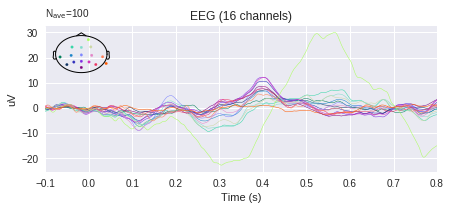

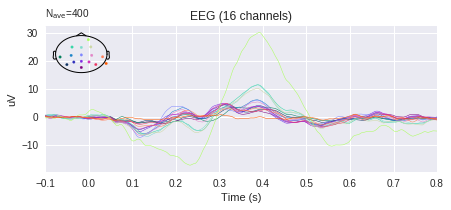

ValueError: ignored

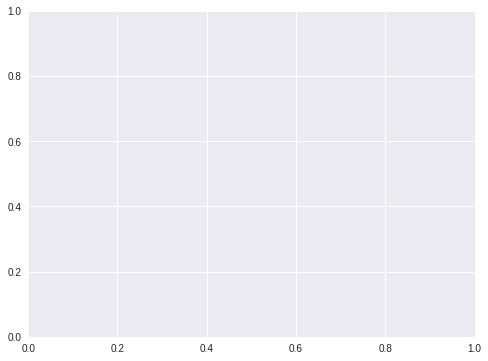

In [19]:
##Preprocessing Settings
event_names = ['Standard','Target']
event_nums = [1,2] # 1 Standard, 2 Target, 9 Response

event_names = ['Standard/Silent','Standard/Sound','Standard/White','Standard/Silent_Low',
               'Target/Silent','Target/Sound','Target/White','Target/Silent_Low']
event_nums = [1,8,5,7,2,3,6,9]

event_id = {event_names[0]: event_nums[0], event_names[1]: event_nums[1]} #create dict

#keep epoch_decim=1 if using frequency_domain

epochs = preprocess(raw, event_id, event_names, plot_psd=False, filter_data=True, 
               eeg_filter_highpass=1, plot_events=False, epoch_time=(-.1,.8), 
               baseline=(-.1,0), rej_thresh_uV=500,
               epoch_decim=1, plot_electrodes=True,
               plot_erp=True)


#Run FeatureEngineer

In [11]:
x_train, x_test, x_val, y_train, y_test, y_val, input_shape, num_classes, class_weights, new_times = FeatureEngineer( epochs,
                    frequency_domain=0, 
                    normalization=True,
                    electrode_median=False,                                                                                                                     
                    wavelet_decim=1,flims=(2,30),
                    f_bins=20,wave_cycles=3,
                    spect_baseline=[-1,-.5],
                    electrodes_out= [13,14,15],
                    #electrodes_out= pick_types(epochs.info, meg=False, eeg=True, eog=False),
                    random_seed=1017,model_type = 'AUTODeep')


Constructing Time Domain Features
Size X before reshape for Auto: (1998, 400, 16)
Size X after reshape for Auto: (1998, 6400)
Normalizing X
Combined X Shape: (1998, 6400)
Combined Y Shape: (1998,)
Y Example (should be 1s & 0s): [0 0 1 1 0 1 0 1 0 0]
X Range: -20.19676:23.260906
Input Shape: (6400,)
('x_train shape:', (1198, 6400))
(1198, 'train samples')
(400, 'test samples')
(400, 'validation samples')
Class Weights: [0.61816305 2.61572052]


# Run CreateModel

In [12]:
model, encoder, decoder = CreateModel(input_shape,num_classes, 
                    model_type='AUTODeep', batch_size = 64)


Creating AUTODeep Model


# TrainTestVal

Training Model:
Training autoencoder:
Train on 1198 samples, validate on 400 samples
Epoch 1/20
1198/1198 [==============================] - 3s 3ms/step - loss: 1.0493 - val_loss: 0.9366
Epoch 2/20
1198/1198 [==============================] - 1s 434us/step - loss: 0.9350 - val_loss: 0.9089
Epoch 3/20
1198/1198 [==============================] - 1s 423us/step - loss: 0.9074 - val_loss: 0.8855
Epoch 4/20
1198/1198 [==============================] - 0s 417us/step - loss: 0.8874 - val_loss: 0.8727
Epoch 5/20
1198/1198 [==============================] - 0s 416us/step - loss: 0.8730 - val_loss: 0.8615
Epoch 6/20
1198/1198 [==============================] - 0s 416us/step - loss: 0.8571 - val_loss: 0.8506
Epoch 7/20
1198/1198 [==============================] - 0s 417us/step - loss: 0.8490 - val_loss: 0.8466
Epoch 8/20
1198/1198 [==============================] - 1s 418us/step - loss: 0.8438 - val_loss: 0.8420
Epoch 9/20
1198/1198 [==============================] - 0s 415us/step - loss: 0.8371 

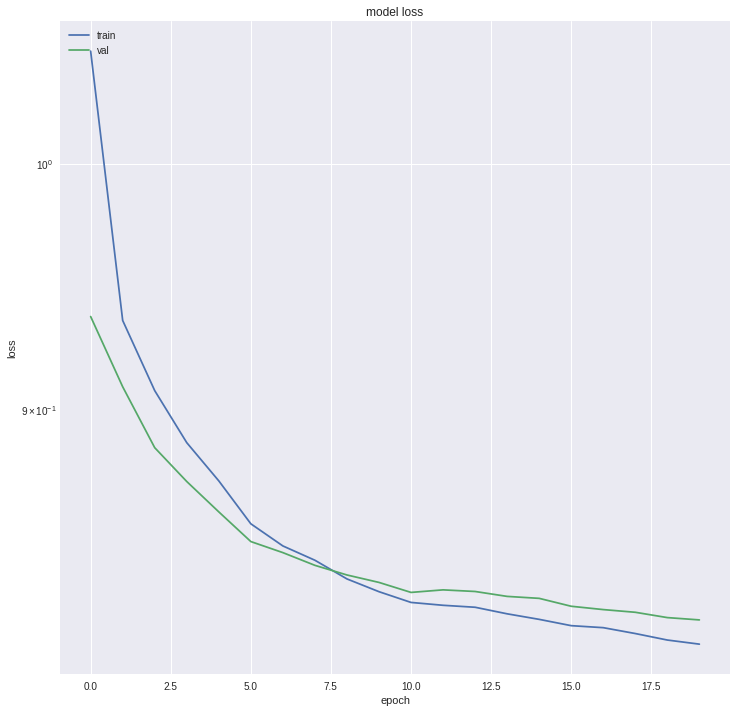

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              6554624   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
__________

In [13]:
traintestval(model, class_weights,
             x_train,x_test,x_val,
             y_train,y_test,y_val,
             batch_size=64,train_epochs=20,
             model_type='AUTODeep')

#Check the results of the autoencoder

x_all size: (1998, 6400)
y_all size: (1998, 2)
encoded_data size: (1998, 16)
decoded_data size: (1998, 6400)
x_all size: (1998, 400, 16)
x_all size: (1998, 6400)
(1998, 400, 16)


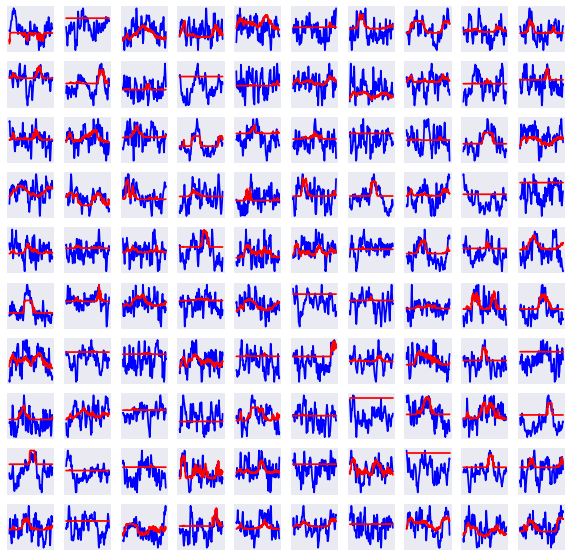

x_all Shape: (1998, 400, 16)
y_all Shape: (1998, 2)


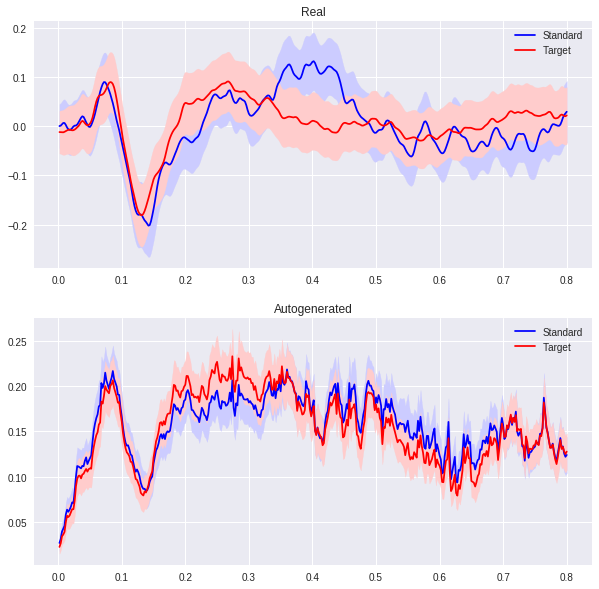

In [15]:
x_all = np.append(x_train,np.append(x_val,x_test,axis=0),axis=0)
y_all = np.append(y_train,np.append(y_val,y_test,axis=0),axis=0)

#encoder input shape and decoder output shape are wrong for the data in the AUTODeep
encoded_data = encoder.predict(x_all)
decoded_data = model.predict(x_all)

print('x_all size: ' + str(x_all.shape))
print('y_all size: ' + str(y_all.shape))

print('encoded_data size: ' + str(encoded_data.shape))
print('decoded_data size: ' + str(decoded_data.shape))
#x_all size: (1587, 640)
#encoded_data size: (1587, 16)
#decoded_data size: (1587, 640)
#(1587, 40, 16)

nchans = len(pick_types(epochs.info, meg=False, eeg=True, eog=False))
ntimes = x_all.shape[1]/nchans
x_all = np.reshape(x_all,(x_all.shape[0],ntimes,nchans))
print('x_all size: ' + str(x_all.shape))
print('x_all size: ' + str(decoded_data.shape))

decoded_data = np.reshape(decoded_data,(decoded_data.shape[0],ntimes,nchans))
print(x_all.shape)

n = 10
chan = epochs.ch_names.index('Pz')
plt.figure(figsize=(10,10))
for i in range(n):
  for j in range(n):
    item_idx = (j*n)+i+1
    ax = plt.subplot(n,n,item_idx)
    plt.plot(x_all[item_idx,:,chan],'b')
    plt.plot(decoded_data[item_idx,:,chan],'r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()




print('x_all Shape: ' + str(x_all.shape))
print('y_all Shape: ' + str(y_all.shape))
chan = epochs.ch_names.index('Pz')

#divide into conditions
cond_zero_real = x_all[y_all[:,0]==0,:,chan]
cond_one_real = x_all[y_all[:,0]==1,:,chan]
cond_zero_decode = decoded_data[y_all[:,0]==0,:,chan]
cond_one_decode = decoded_data[y_all[:,0]==1,:,chan]

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
zero_err = np.std(cond_zero_real, axis=0)/10
one_err = np.std(cond_one_real, axis=0)/10
ax.fill_between(new_times, np.mean(cond_zero_real, axis=0)-zero_err, np.mean(cond_zero_real, axis=0)+zero_err,color=[.8,.8,1])
ax.plot(new_times,np.mean(cond_zero_real, axis=0),'b',label=event_names[0])
ax.fill_between(new_times, np.mean(cond_one_real, axis=0)-one_err, np.mean(cond_one_real, axis=0)+one_err,color=[1,.8,.8])
ax.plot(new_times,np.mean(cond_one_real, axis=0),'r',label=event_names[1])
plt.title('Real')
ax.legend()

ax = plt.subplot(2,1,2)
zero_err = np.std(cond_zero_decode, axis=0)/10
one_err = np.std(cond_one_decode, axis=0)/10
ax.fill_between(new_times, np.mean(cond_zero_decode, axis=0)-zero_err, np.mean(cond_zero_decode, axis=0)+zero_err,color=[.8,.8,1])
ax.plot(new_times,np.mean(cond_zero_decode, axis=0),'b',label=event_names[0])
ax.fill_between(new_times, np.mean(cond_one_decode, axis=0)-one_err, np.mean(cond_one_decode, axis=0)+one_err,color=[1,.8,.8])
ax.plot(new_times,np.mean(cond_one_decode, axis=0),'r',label=event_names[1])
plt.title('Autogenerated')
ax.legend()
plt.show()
